In [ ]:
# ##TEST##
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input
# from tensorflow.keras.preprocessing import image
# import numpy as np

# model = MobileNetV2(weights='imagenet')
# img = image.load_img("/kaggle/input/flowers/flower_photos_v1/daisy/100080576_f52e8ee070_n.jpg", target_size = (224, 224))
# img = image.img_to_array(img)
# img 
# img = np.expand_dims(img, axis = 0)
# x = preprocess_input(img)

# preds = model.predict(x)
# decode_predictions(preds, top=3)[0]

# !pip install rembg
# !pip install onnxruntime

# from rembg import remove
# from PIL import Image

# input = Image.open("/kaggle/input/moreflowers/New folder/carnation/100556260_e63b95e283_c.jpg")
# output = remove(input)
# output.save("/kaggle/working/100556260_e63b95e283_c.jpg")

In [ ]:
##Phần transfer learning với mô hình EfficientNetB2##

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

2025-06-15 09:07:30.980249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749978451.409302      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749978451.535626      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_ds_1 = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/mushroomcankill/Agaric (2)",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = [260, 260],
    batch_size = 32
)


valid_ds_1 = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/mushroomcankill/Agaric (2)",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = [260, 260],
    batch_size = 16
)

Found 6502 files belonging to 5 classes.
Using 5202 files for training.


I0000 00:00:1749978528.255889      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749978528.256655      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 6502 files belonging to 5 classes.
Using 1300 files for validation.


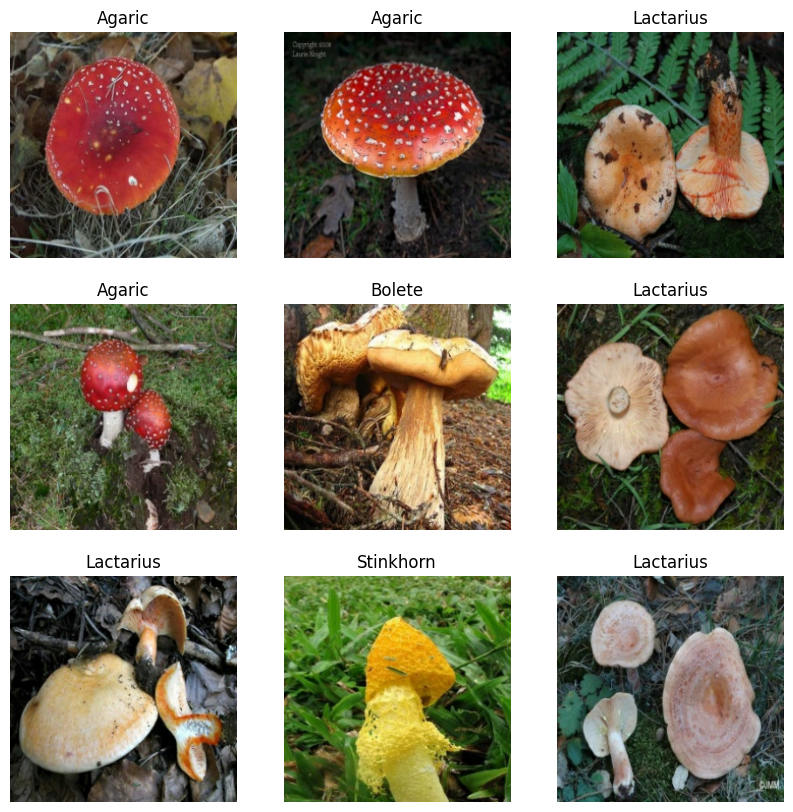

In [4]:
for img, label in train_ds_1.take(1):
    plt.figure(figsize = (10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(train_ds_1.class_names[label[i]])
        plt.axis("off")

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(280, 280),
    tf.keras.layers.RandomCrop(260, 260),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.055),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
])

In [4]:
train_ds_1 = train_ds_1.map(lambda x, y : (data_augmentation(x, training=True), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_1 = train_ds_1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds_1 = valid_ds_1.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
def efficientnet(input_shape=(260, 260, 3), num_classes = 5, weight_decay=1e-4):
    base_model = tf.keras.applications.EfficientNetB2(
        input_shape = input_shape,
        include_top = False,
        weights = 'imagenet'
    )
    base_model.trainable = False
    base_model._name = "efficientnetb2"
    inputs = tf.keras.Input(shape = input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
]

In [8]:
def train_model(model, train_ds_1, valid_ds_1, epochs = 30, learning_rate = 1e-3):
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    history = model.fit(
        train_ds_1,
        validation_data = valid_ds_1,
        epochs = epochs,
        callbacks = callbacks,
        verbose = 1
    )
    return model, history

In [9]:
def fine_tune_model(model, train_ds_1, valid_ds_1, epochs = 35, learning_rate = 1e-5):
    base_model = model.get_layer("efficientnetb2")
    base_model.trainable = True
    fine_tune_at = int(len(base_model.layers) * 0.90)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'],
    )

    history = model.fit(
        train_ds_1,
        validation_data = valid_ds_1,
        epochs = epochs,
        callbacks = callbacks,
        verbose = 1
    )
    return model, history

In [10]:
tf.keras.backend.clear_session()

In [11]:
model = efficientnet(input_shape=(260, 260, 3), num_classes = 5)
base_model = model.get_layer("efficientnetb2")

print("Training mode")
model, history1 = train_model(model, train_ds_1, valid_ds_1, epochs = 10)
print("Finetune mode")
model, history2 = fine_tune_model(model, train_ds_1, valid_ds_1, 
                epochs = 15)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training mode
Epoch 1/10


I0000 00:00:1749978697.168652      99 service.cc:148] XLA service 0x79430826f090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749978697.170583      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749978697.170606      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749978699.942800      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749978704.233420      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978704.418675      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/163 ━━━━━━━━━━━━━━━━━━━━ 7:10:58 160s/step - accuracy: 0.1875 - loss: 1.8634

I0000 00:00:1749978718.244321      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 44/163 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.3428 - loss: 1.5114

E0000 00:00:1749978726.121902      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978726.286978      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5062 - loss: 1.1937

E0000 00:00:1749978753.429111     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978753.590856     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978765.056556      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978765.196247      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 322ms/step - accuracy: 0.5069 - loss: 1.1920 - val_accuracy: 0.8477 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.7722 - loss: 0.6270 - val_accuracy: 0.8777 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.8172 - loss: 0.5139 - val_accuracy: 0.8815 - val_loss: 0.3462 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8453 - loss: 0.4524 - val_accuracy: 0.8900 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8530 - loss: 0.4136 - val_accuracy: 0.8969 - val_loss: 0.2959 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8545 - loss: 0.3951 - val_accuracy: 0.9015 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8626 - loss: 0.38

E0000 00:00:1749978942.911992      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978943.058382      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978943.497022      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749978943.667502      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 315ms/step - accuracy: 0.7801 - loss: 0.6068 - val_accuracy: 0.8869 - val_loss: 0.3195 - learning_rate: 1.0000e-05
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.8046 - loss: 0.5235 - val_accuracy: 0.8900 - val_loss: 0.3229 - learning_rate: 1.0000e-05
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8276 - loss: 0.4793 - val_accuracy: 0.8946 - val_loss: 0.3189 - learning_rate: 1.0000e-05
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.8377 - loss: 0.4562 - val_accuracy: 0.8954 - val_loss: 0.3164 - learning_rate: 1.0000e-05
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8655 - loss: 0.4079 - val_accuracy: 0.8946 - val_loss: 0.3128 - learning_rate: 1.0000e-05
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.8577 - loss: 0.3917 - val_accuracy: 0.8985 - val_loss: 0.3080 - learning_rate: 1.0000e-05
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step -

In [12]:
y_true = []
y_pred = []

for images, labels in valid_ds_1:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       230
           1       0.87      0.93      0.89       243
           2       0.84      0.80      0.82       320
           3       0.77      0.82      0.80       231
           4       0.99      0.97      0.98       276

    accuracy                           0.89      1300
   macro avg       0.89      0.89      0.89      1300
weighted avg       0.89      0.89      0.89      1300



In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()

In [ ]:
plot_training(history1)
plot_training(history2)

In [ ]:
model.save("efficientnetb2_medicine.h5")

In [ ]:
##Phần sử dụng HOG + Histogram để triết xuất đặc trưng với optuna để tìm parameters tốt nhất cho mô hình random forest##

In [1]:
import numpy as np
import pandas as pd
import os
import optuna.visualization as vis
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
from skimage import color, io
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import cv2
import optuna
from joblib import dump

2025-06-18 07:34:40.617313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750232080.865741      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750232080.939669      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/mushroomcankill/Agaric (2)',
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = (128, 128),
    label_mode = 'int',
    shuffle = 'True',
    batch_size = 32
)

valid_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/mushroomcankill/Agaric (2)',
    validation_split = 0.2,
    seed = 42,
    subset = 'validation',
    image_size = (128, 128),
    shuffle = 'True',
    batch_size = 32
)

Found 6502 files belonging to 5 classes.
Using 5202 files for training.


I0000 00:00:1750232163.224146      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750232163.225025      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 6502 files belonging to 5 classes.
Using 1300 files for validation.


In [3]:
data_augmentation = A.Compose([
    A.Resize(140, 140),
    A.RandomCrop(128, 128),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.GaussianBlur(p=0.2)
])

In [4]:
def extract_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_feat = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

    hist_feat = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_feat.extend(hist)

    return np.concatenate([hog_feat, hist_feat])

In [5]:
def extract_features_with_visualization(image):
    image_resized = cv2.resize(image, (128, 128))
    
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    
    hog_feat, hog_image = hog(gray, 
                             pixels_per_cell=(8, 8), 
                             cells_per_block=(2, 2), 
                             feature_vector=True, 
                             visualize=True)

    hist_feat = []
    hist_data = []
    
    colors = ['red', 'green', 'blue']
    for i in range(3):
        hist = cv2.calcHist([image_resized], [i], None, [32], [0, 256])
        hist_normalized = cv2.normalize(hist, hist).flatten()
        hist_feat.extend(hist_normalized)
        hist_data.append((hist.flatten(), colors[i]))
    
    combined_features = np.concatenate([hog_feat, hist_feat])
    
    return {
        'combined_features': combined_features,
        'hog_features': hog_feat,
        'hist_features': hist_feat,
        'hog_image': hog_image,
        'hist_data': hist_data,
        'original': image_resized,
        'gray': gray
    }

In [6]:
def visualize_single_image(image_path):

    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    result = extract_features_with_visualization(image_rgb)
    
    fig = plt.figure(figsize=(8, 6))
    
    plt.subplot(2, 4, 1)
    plt.imshow(result['original'])
    plt.title('Ảnh gốc (128x128)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(result['hog_image'], cmap='gray')
    plt.title('HOG Features Visualization', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    for hist_values, color in result['hist_data']:
        plt.plot(hist_values, color=color, linewidth=2, alpha=0.8, label=color.upper())
    plt.title('Color Histograms', fontsize=14, fontweight='bold')
    plt.xlabel('Pixel Value Bins')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 4, 7)
    hog_len = len(result['hog_features'])
    hist_len = len(result['hist_features'])
    
    plt.plot(range(hog_len), result['hog_features'], 'b-', alpha=0.7, label=f'HOG ({hog_len} features)')
    plt.plot(range(hog_len, hog_len + hist_len), result['hist_features'], 'r-', alpha=0.7, label=f'Histogram ({hist_len} features)')
    plt.title('Combined Features', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"PHÂN TÍCH ẢNH: {image_path.split('/')[-1]}")
    print(f"{'='*60}")
    print(f"HOG Features: {len(result['hog_features'])} chiều")
    print(f"Histogram Features: {len(result['hist_features'])} chiều")
    print(f"Tổng Features: {len(result['combined_features'])} chiều")


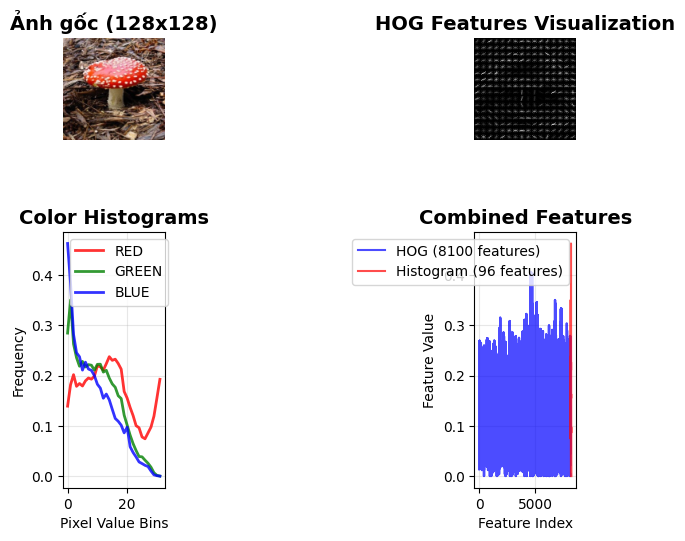


PHÂN TÍCH ẢNH: 01A5SDOXXUEF.jpg
HOG Features: 8100 chiều
Histogram Features: 96 chiều
Tổng Features: 8196 chiều


In [7]:
visualize_single_image("/kaggle/input/mushroomcankill/Agaric (2)/Agaric/01A5SDOXXUEF.jpg")

In [8]:
def dataset(train_data, augment_fn=None):
    X, y = [], []
    for img_batch, label_batch in train_data:
        for img, label in zip(img_batch, label_batch):
            img_np = (img.numpy() * 255)

            if augment_fn is not None:
                img_np = augment_fn(image=img_np)['image']
            
            features = extract_features(img_np)

            X.append(features)
            y.append(label.numpy())

    return X, y

In [9]:
X_train, y_train = dataset(train_data, augment_fn = data_augmentation)
X_valid, y_valid = dataset(valid_data, augment_fn = None)

In [10]:
len(X_valid)

1300

In [11]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500, step = 50)
    max_depth = trial.suggest_int("max_depth", 5, 50, step = 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    trial.set_user_attr("model", model)

    return accuracy
    

In [ ]:
rf1 = optuna.create_study(direction="maximize")
rf1.optimize(objective, n_trials = 50)

[I 2025-06-18 07:58:24,830] A new study created in memory with name: no-name-b83d4ab4-dc03-4939-8647-fe63cbeb9880
[I 2025-06-18 08:00:14,945] Trial 0 finished with value: 0.4453846153846154 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4453846153846154.
[I 2025-06-18 08:01:20,435] Trial 1 finished with value: 0.42538461538461536 and parameters: {'n_estimators': 250, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.4453846153846154.
[I 2025-06-18 08:02:07,478] Trial 2 finished with value: 0.4076923076923077 and parameters: {'n_estimators': 200, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.4453846153846154.
[I 2025-06-18 08:03:02,623] Trial 3 finished with value: 0.41923076923076924 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with val

In [ ]:
print("Best params from Optuna:", rf1.best_params)
print("Validation accuracy:", rf1.best_value)

In [ ]:
# vis.plot_param_importances(rf)

In [ ]:
best_model = rf1.best_trial.user_attrs["model"]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = best_model.predict(X_valid)
print(classification_report(y_valid, y_pred))

In [ ]:
dump(best_model, 'rf_model.joblib')

In [ ]:
##Phần sử dụng lbp để triết xuất đặc trưng với optuna để tìm parameters tốt nhất cho mô hình random forest##

In [25]:
import numpy as np
import pandas as pd
import os
import optuna.visualization as vis
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
from skimage import color, io
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import cv2
import optuna
from joblib import dump

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/mushroomcankill/Agaric (2)',
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = (128, 128),
    label_mode = 'int',
    shuffle = 'True',
    batch_size = 32
)

valid_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/mushroomcankill/Agaric (2)',
    validation_split = 0.2,
    seed = 42,
    subset = 'validation',
    image_size = (128, 128),
    shuffle = 'True',
    batch_size = 32
)

In [ ]:
def lbp_feature(image):
    radius = 1
    n_points = 8 * radius
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    return lbp

In [ ]:
def visualize_single_image(image_path):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return
    
    lbp_image = lbp_feature(image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh gốc')

    plt.subplot(1, 2, 2)
    plt.imshow(lbp_image, cmap="gray")
    plt.title("Ảnh đã trích xuất LBP")
    
    plt.show()

In [ ]:
visualize_single_image("/kaggle/input/mushroomcankill/Agaric (2)/Lactarius/01UILUSXCMFJ.jpg")

In [ ]:
def dataset(train_data, augment_fn=None):
    X, y = [], []
    for img_batch, label_batch in train_data:
        for img, label in zip(img_batch, label_batch):
            img_np = (img.numpy() * 255).astype(np.uint8)

            if augment_fn is not None:
                img_np = augment_fn(image=img_np)['image']
            
            features = lbp_feature(img_np)

            X.append(features)
            y.append(label.numpy())

    return X, y

In [ ]:
X_train, y_train = dataset(train_data, augment_fn = data_augmentation)
X_valid, y_valid = dataset(valid_data, augment_fn = None)

In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)

X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500, step = 50)
    max_depth = trial.suggest_int("max_depth", 5, 50, step = 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    trial.set_user_attr("model", model)

    return accuracy
    

In [ ]:
rf2 = optuna.create_study(direction="maximize")
rf2.optimize(objective, n_trials = 50)

In [ ]:
print("Best params from Optuna:", rf2.best_params)
print("Validation accuracy:", rf2.best_value)

In [ ]:
best_model = rf2.best_trial.user_attrs["model"]

In [ ]:
y_pred = best_model.predict(X_valid)
print(classification_report(y_valid, y_pred))

In [ ]:
##Phần sử dụng ResNet50 để triết xuất đặc trưng với optuna để tìm parameters tốt nhất cho mô hình random forest##

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
from tqdm import tqdm

2025-06-15 09:42:10.334616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749980530.581206      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749980530.649981      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/mushroomcankill/Agaric (2)',
    seed = 42,
    image_size = (224, 224),
    label_mode = 'int',
    shuffle = 'True'
)

Found 6502 files belonging to 5 classes.


In [26]:
# train_data = train_data.map(lambda x, y : (data_augmentation(x, training=True), y))

In [17]:
def dataset(train_data):
    X, y = [], []
    for img_batch, label_batch in train_data:
        for img, label in zip(img_batch, label_batch):
            X.append(img)
            y.append(label.numpy())

    return X, y

In [18]:
X_train, y_train = dataset(train_data)

In [19]:
X_train = np.array(X_train)

In [6]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
X_preprocessed = preprocess_input(X_train)

In [21]:
features = resnet_model.predict(X_preprocessed, batch_size=32, verbose=1)
print("Feature shape:", features.shape)

204/204 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step
Feature shape: (6502, 2048)


In [ ]:
## Hiện ra các ảnh để được triết xuất đặc trưng

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, X_test = train_test_split(
    features, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [29]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500, step = 50)
    max_depth = trial.suggest_int("max_depth", 5, 50, step = 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    trial.set_user_attr("model", model)

    return accuracy
    

In [30]:
rf2 = optuna.create_study(direction="maximize")
rf2.optimize(objective, n_trials = 50)

[I 2025-06-15 10:02:34,608] A new study created in memory with name: no-name-3d46ff3a-529f-4ba8-9d2d-f06079ad4500
[I 2025-06-15 10:03:06,607] Trial 0 finished with value: 0.8647194465795542 and parameters: {'n_estimators': 200, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8647194465795542.
[I 2025-06-15 10:03:30,308] Trial 1 finished with value: 0.8693312836279785 and parameters: {'n_estimators': 150, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8693312836279785.
[I 2025-06-15 10:04:43,980] Trial 2 finished with value: 0.8762490392006149 and parameters: {'n_estimators': 450, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8762490392006149.
[I 2025-06-15 10:06:00,677] Trial 3 finished with value: 0.8724058416602614 and parameters: {'n_estimators': 450, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with valu

In [31]:
print("Best params from Optuna:", rf2.best_params)
print("Validation accuracy:", rf2.best_value)

Best params from Optuna: {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 2}
Validation accuracy: 0.8808608762490392


In [32]:
best_model = rf2.best_trial.user_attrs["model"]

In [33]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       252
           1       0.86      0.92      0.89       260
           2       0.78      0.87      0.82       301
           3       0.87      0.69      0.77       229
           4       0.94      0.96      0.95       259

    accuracy                           0.88      1301
   macro avg       0.89      0.88      0.88      1301
weighted avg       0.88      0.88      0.88      1301



In [ ]:
import joblib
joblib.dump(rf, "random_forest_model.joblib")

In [ ]:
##Sử dụng lệnh prediction để cho thấy mấy ảnh nhận diện đúng sai của từng mô hình